In [1]:
import os
import requests
import fsspec
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

from stormevents import StormEvent
from stormevents.usgs import sensors, events
from cartopy.feature import NaturalEarthFeature

from datetime import datetime
from shapely.geometry import MultiPolygon
from shapely.ops import polygonize
from searvey.coops import coops_product_within_region, coops_stations_within_region

In [2]:
def get_storm_track_date(storm_track, advisory):
    for idx in storm_track.linestrings[advisory]:
        plot_date = idx #xy_line = storm_track.linestrings[advisory][idx].xy
    return plot_date

In [3]:
def get_storm_track_line(storm_track, advisory):
    for idx in storm_track.linestrings[advisory]:
        xy_line = storm_track.linestrings[advisory][idx].xy
    return xy_line

In [4]:
def format_datetime_for_coops(storm_datetime):
    return datetime(storm_datetime.year, storm_datetime.month, storm_datetime.day, storm_datetime.hour, storm_datetime.minute)

In [5]:
def plot_stations(df_obs,storm_track):
    figure, axis = plt.subplots(1, 1)
    figure.set_size_inches(12, 12/1.6)
    
    track_line = get_storm_track_line(storm_track, 'BEST')
    
    axis.scatter(df_obs[df_obs['Source']=='COOPS']['Longitude'], df_obs[df_obs['Source']=='COOPS']['Latitude'], marker='s', s=15, label='COOPS')
    axis.scatter(df_obs[df_obs['Source']=='USGS']['Longitude'], df_obs[df_obs['Source']=='USGS']['Latitude'], marker='x', s=22, label='USGS')
    
    xlim = axis.get_xlim()
    ylim = axis.get_ylim()
    
    axis.plot(*track_line, c='black', linestyle='dashed', label='BEST track', zorder=-1)
    gdf_countries.plot(color='lightgrey', ax=axis, zorder=-5)
    
    axis.set_xlim(xlim)
    axis.set_ylim(ylim)

    plt.legend()
    plt.title(f'{storm_track.name}_{storm_track.year}')
    plt.savefig(f'{storm_track.name}_{storm_track.year}_COOPS_and_USGS_stations.png')

**Define the storm**

In [6]:
storm_name = 'florence'
storm_year = 2018

Retrieve storm from stormevent

In [7]:
storm = StormEvent(name=storm_name.upper(),
                   year=storm_year)

/root/miniconda3/envs/nhc_colab/lib/python3.10/site-packages/stormevents/nhc/storms.py:64: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  storms = pandas.read_csv(


## COOPS Max Elevations

In [8]:
storm_best_track = storm.track()

In [9]:
storm_date_str = get_storm_track_date(storm_best_track, 'BEST')
storm_start_date = storm_best_track.start_date
storm_end_date = storm_best_track.end_date 

Define COOPS domain 

In [10]:
isotach_limit = 34
isotach_domain = MultiPolygon(list(polygonize(storm_best_track.wind_swaths(wind_speed=isotach_limit)['BEST'][storm_date_str].exterior)))

Retrieve COOPS observations

In [11]:
domain_stations = coops_stations_within_region(region=isotach_domain)
domain_stations = domain_stations.reset_index()

coops_start_date = format_datetime_for_coops(storm_start_date)
coops_end_date = format_datetime_for_coops(storm_end_date)

coops_water_level = coops_product_within_region('water_level', 
                                                datum='NAVD',
                                                region=isotach_domain,
                                                start_date=coops_start_date,
                                                end_date=coops_end_date)

Obtain names of COOPS stations

In [12]:
st_names = []
for station in coops_water_level.nos_id.values:
    temp = domain_stations[domain_stations['nos_id']==int(station)]['name'].values[0]
    st_names.append(temp)

Finalize COOPS dataset

In [13]:
df_COOPS = pd.DataFrame({'Station_id':coops_water_level.nos_id.values.tolist(),
                         'Station_name':st_names,
                         'Latitude': coops_water_level.y.values.tolist(),
                         'Longitude': coops_water_level.x.values.tolist(),
                         'Max_obs_meter': coops_water_level.v.max('t').values.tolist()})

df_COOPS['Event'] = f'{storm.name}_{storm.year}'
df_COOPS['Source'] = 'COOPS'

In [14]:
df_COOPS

,Station_id,Station_name,Latitude,Longitude,Max_obs_meter,Event,Source
0,8652587,Oregon Inlet Marina,35.795689,-75.548187,0.688,FLORENCE_2018,COOPS
1,8670870,Fort Pulaski,32.034691,-80.903030,1.642,FLORENCE_2018,COOPS
2,8661070,Springmaid Pier,33.655560,-78.916389,1.326,FLORENCE_2018,COOPS
3,8656483,"Beaufort, Duke Marine Lab",34.717331,-76.670662,1.587,FLORENCE_2018,COOPS
4,8665530,Charleston,32.780830,-79.923607,1.341,FLORENCE_2018,COOPS
5,8658120,Wilmington,34.227501,-77.953613,1.731,FLORENCE_2018,COOPS
6,8658163,Wrightsville Beach,34.213310,-77.786690,1.778,FLORENCE_2018,COOPS
7,8654467,USCG Station Hatteras,35.208611,-75.704193,0.615,FLORENCE_2018,COOPS
8,8651370,Duck,36.183300,-75.746696,1.195,FLORENCE_2018,COOPS


## USGS Sensors' Max Elevations

First check it there are USGS data records available for the storm

In [15]:
if storm.usgs_id is None:
    print(f"USGS data records are not available for {storm.name}_{storm.year}")

/root/miniconda3/envs/nhc_colab/lib/python3.10/site-packages/stormevents/nhc/storms.py:64: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  storms = pandas.read_csv(


Get specification of instruments used for a given event

In [16]:
instruments = requests.get('https://stn.wim.usgs.gov/STNServices/Instruments/FilteredInstruments.json')
df_inst = pd.DataFrame(instruments.json())

filter instruments for a specific storm/application

In [17]:
eventName = f'{storm.year} {storm.name.capitalize()}'
sensor_type_id = sensors.SensorType.PRESSURE_TRANSDUCER.value
deployment_type_id = [sensors.DeploymentType.WATER_LEVEL.value, sensors.DeploymentType.WAVE_HEIGHT.value]

In [18]:
mask_inst = (
    df_inst['sensor_type_id']==sensor_type_id
) & (
    df_inst['eventName']==eventName
) & (
    (df_inst['deployment_type_id'].isin(deployment_type_id))
)

In [19]:
df_inst = df_inst[mask_inst]

In [20]:
site_id = df_inst.site_id.values  # will be used for files retrieval

Then retrieve list of files corresponding to these sensors during the event

In [21]:
files = requests.get('https://stn.wim.usgs.gov/STNServices/Files.json')
df_files = pd.DataFrame(files.json())

filter files for a storm/sensors

In [22]:
if storm.year < 2015:
    # old file format
    mask_file = (
        df_files['site_id'].isin(site_id)
    ) & (
        df_files['name'].str.contains(".txt")
    ) & (
        df_files['path'].str.contains(f"EVENT_{storm.usgs_id}")
    )
else:
    # new file format:
    mask_file = (
        df_files['site_id'].isin(site_id)
    ) & (
        df_files['name'].str.contains("stormtide_unfiltered.nc")
    ) & (
        df_files['path'].str.contains(f"EVENT_{storm.usgs_id}")
    )

In [23]:
df_files = df_files[mask_file]

In [24]:
df_files = df_files.drop_duplicates(subset=['name']) # drop duplicate files

Finally, loop through filtered files and obtain max elevations

In [25]:
fs = fsspec.filesystem('simplecache', target_protocol='http')

***Storm After 2015***

In [26]:
# filterd elevations in [m]

if storm.year >= 2015:
    file_id_list = []
    name_list = []
    site_id_list = []
    max_ele_unfilter_list = []
    max_ele_filter_list = []

    for index, row in df_files.iterrows():
        file_id = row['file_id']
        name = row['name']
        file_site_id = row['site_id']

        try:
            f_temp = fs.open(f'https://stn.wim.usgs.gov/STNServices/Files/{file_id}/Item')
            ds_temp = xr.open_dataset(f_temp.name, engine='netcdf4')
            temp_max_unfilter = ds_temp['unfiltered_water_surface_height_above_reference_datum'].max('time').values.tolist()
            temp_max_filter = ds_temp['water_surface_height_above_reference_datum'].max('time').values.tolist()

            file_id_list.append(file_id)
            name_list.append(name)
            site_id_list.append(file_site_id)
            max_ele_unfilter_list.append(temp_max_unfilter)
            max_ele_filter_list.append(temp_max_filter)
        except:
            print(f"Couldn't find file/max_elev for a file named: {name}") 

***Storms Between 2010 and 2015***

In [27]:
# only unfiltered for now!

if (2010< storm.year <2015):
    file_id_list = []
    name_list = []
    site_id_list = []
    max_ele_unfilter_list = []
    max_ele_filter_list = []

    for index, row in df_files.iterrows():
        file_id = row['file_id']
        name = row['name']
        file_site_id = row['site_id']

        try:
            f_temp = fs.open(f'https://stn.wim.usgs.gov/STNServices/Files/{file_id}/Item')
            ds_temp = pd.read_csv(f_temp, sep='\t') # first read the entrie file
            skiprows = 1 + (ds_temp[ds_temp['Unnamed: 1']=='elevation'].index.values[0]) # find how many rows should be skipped

            f_temp = fs.open(f'https://stn.wim.usgs.gov/STNServices/Files/{file_id}/Item') # then open it again and skip headers 
            ds_temp = pd.read_csv(f_temp, skiprows=skiprows, sep='\t')

            temp_max_unfilter = ds_temp['elevation'].max()
            temp_max_filter = temp_max_unfilter * 0.3048 # to convert ft to meter

            file_id_list.append(file_id)
            name_list.append(name)
            site_id_list.append(file_site_id)
            max_ele_unfilter_list.append(temp_max_unfilter)
            max_ele_filter_list.append(temp_max_filter)
        except:
            print(f"Couldn't find file/max_elev for a file_id: {file_id} ; name: {name}") 

***Storm Before 2010***

In [28]:
# (only unfiltered for now)!

if storm.year <2010:
    file_id_list = []
    name_list = []
    site_id_list = []
    max_ele_unfilter_list = []
    max_ele_filter_list = []

    for index, row in df_files.iterrows():
        file_id = row['file_id']
        name = row['name']
        file_site_id = row['site_id']

        try:
            f_temp = fs.open(f'https://stn.wim.usgs.gov/STNServices/Files/{file_id}/Item')       
            ds_temp = pd.read_csv(f_temp, delimiter='\t', skiprows=27, on_bad_lines='skip')
            temp_max_unfilter = ds_temp['elevation'].max()
            temp_max_filter = temp_max_unfilter * 0.3048 # to convert ft to meter

            file_id_list.append(file_id)
            name_list.append(name)
            site_id_list.append(file_site_id)
            max_ele_unfilter_list.append(temp_max_unfilter)
            max_ele_filter_list.append(temp_max_filter)
        except:
            print(f"Couldn't find file/max_elev for a file_id: {file_id} ; name: {name}") 

In [29]:
df_tmp = pd.DataFrame({'file_id':file_id_list,
                       'name':name_list, 
                       'site_id':site_id_list, 
                       'max_elev_unfiltered':max_ele_unfilter_list,
                       'max_elev_filtered':max_ele_filter_list
                      })

In [30]:
# merge sensor max elevation table with instrument table
df_tmp = pd.merge(df_tmp,df_inst,on='site_id', how="left")

In [31]:
df_USGS = pd.DataFrame()
df_USGS['Station_id'] = df_tmp['site_id']
df_USGS['Station_name'] = df_tmp['name']
df_USGS['Latitude'] = df_tmp['latitude']
df_USGS['Longitude'] = df_tmp['longitude']
df_USGS['Max_obs_meter'] = df_tmp['max_elev_filtered']
df_USGS['Event'] = f'{storm.name}_{storm.year}'
df_USGS['Source'] = 'USGS'

In [32]:
# Remove duplicate records (if any) 
if df_USGS.Station_name.duplicated().any():
    df_USGS = df_USGS.drop_duplicates(subset=['Station_name'])

In [33]:
df_USGS

,Station_id,Station_name,Latitude,Longitude,Max_obs_meter,Event,Source
0,17814,Little_Neck_FinalWL_stormtide_unfiltered.nc,36.855627,-75.983591,0.732928,FLORENCE_2018,USGS
1,6801,Back_stormtide_unfiltered.nc,37.110683,-76.319072,0.883321,FLORENCE_2018,USGS
2,26859,365017076174700_stormtide_unfiltered.nc,36.838310,-76.296650,0.893117,FLORENCE_2018,USGS
3,22567,01670060_stormtide_unfiltered.nc,37.379080,-76.426110,1.054975,FLORENCE_2018,USGS
4,14326,SCHOR14326_20180919_stormtide_unfiltered.nc,33.888333,-78.592778,1.842404,FLORENCE_2018,USGS
...,...,...,...,...,...,...,...
165,27844,NCNEW27844_stormtide_unfiltered.nc,34.209218,-77.792989,2.955151,FLORENCE_2018,USGS
166,27847,NCNEW27847_stormtide_unfiltered.nc,34.210384,-77.795025,1.897711,FLORENCE_2018,USGS
167,27848,NCNEW27848_stormtide_unfiltered.nc,34.211816,-77.797411,2.012863,FLORENCE_2018,USGS
168,27845,NCNEW27845_stormtide_unfiltered.nc,34.212415,-77.798486,1.945491,FLORENCE_2018,USGS


**Combine Datasets**

In [34]:
if storm.usgs_id is None:
    df_obs = df_COOPS
else:
    df_obs = pd.concat([df_COOPS,df_USGS])

**Quality control**

<Axes: xlabel='Source', ylabel='Max_obs_meter'>

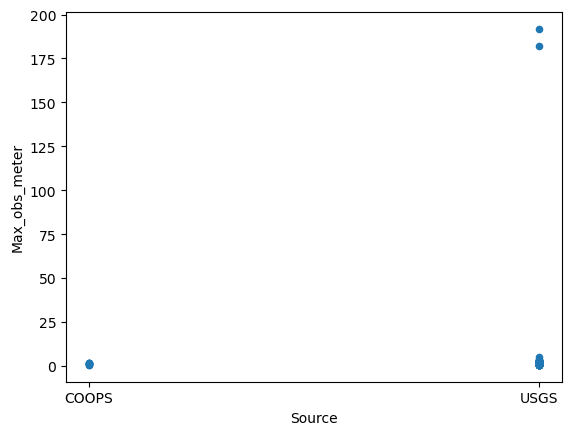

In [35]:
df_obs.plot.scatter(x='Source', y='Max_obs_meter')

In [36]:
# Remove outliers and negative values 
# values bigger than 10*median are considered as outlier
mask_qc = (
    df_obs['Max_obs_meter'] > 0
) & (
    df_obs['Max_obs_meter'] < (10*df_obs['Max_obs_meter'].median())
)

In [37]:
df_obs = df_obs[mask_qc]
df_obs = df_obs.reset_index(drop=True)
df_obs

,Station_id,Station_name,Latitude,Longitude,Max_obs_meter,Event,Source
0,8652587,Oregon Inlet Marina,35.795689,-75.548187,0.688000,FLORENCE_2018,COOPS
1,8670870,Fort Pulaski,32.034691,-80.903030,1.642000,FLORENCE_2018,COOPS
2,8661070,Springmaid Pier,33.655560,-78.916389,1.326000,FLORENCE_2018,COOPS
3,8656483,"Beaufort, Duke Marine Lab",34.717331,-76.670662,1.587000,FLORENCE_2018,COOPS
4,8665530,Charleston,32.780830,-79.923607,1.341000,FLORENCE_2018,COOPS
...,...,...,...,...,...,...,...
172,27844,NCNEW27844_stormtide_unfiltered.nc,34.209218,-77.792989,2.955151,FLORENCE_2018,USGS
173,27847,NCNEW27847_stormtide_unfiltered.nc,34.210384,-77.795025,1.897711,FLORENCE_2018,USGS
174,27848,NCNEW27848_stormtide_unfiltered.nc,34.211816,-77.797411,2.012863,FLORENCE_2018,USGS
175,27845,NCNEW27845_stormtide_unfiltered.nc,34.212415,-77.798486,1.945491,FLORENCE_2018,USGS


**Plot Observation Points**

In [38]:
gdf_countries = gpd.GeoSeries(NaturalEarthFeature(category='physical', 
                                                  scale='10m', 
                                                  name='land',
                                                 ).geometries(), 
                              crs=4326)

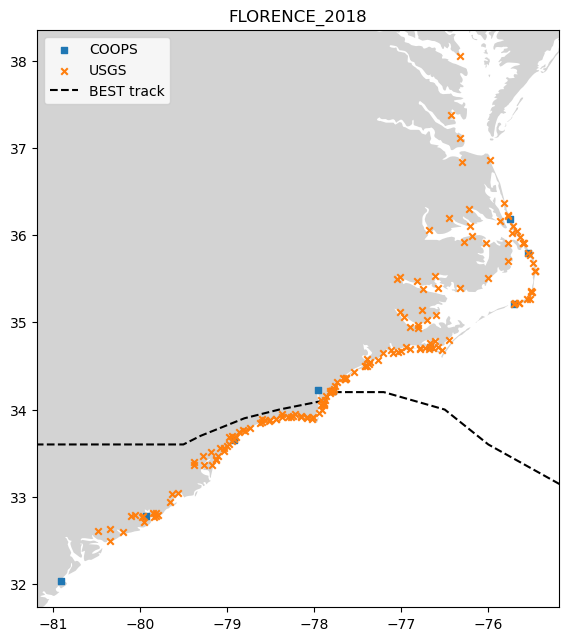

In [39]:
plot_stations(df_obs,storm_best_track)

**Save Filtered Max Elevations**

In [40]:
df_obs.to_csv(f'obs_{storm.name}_{storm.year}.csv')